In [88]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import pandas as pd
import numpy as np
from pacmagic_deeplearning.modeling.classifiers.bayesian.train_utils import make_performance_uncertainty_plot, cross_entropy

from utils import get_weight_tensor_from_class_weights, train, plot_calibration_curve, make_precision_accuracy_plot
from utils import NN

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
X_train = pd.read_csv('../../data/MIMIC/X_train_processed.csv')
y_train = pd.read_csv('../../data/MIMIC/y_train.csv')

X_test = pd.read_csv('../../data/MIMIC/X_test_processed.csv')
y_test = pd.read_csv('../../data/MIMIC/y_test.csv')

In [90]:
data = torch.from_numpy(X_train.values).float()
target = torch.from_numpy(y_train.values).float()

data_val = torch.from_numpy(X_test.values).float()
target_val = torch.from_numpy(y_test.values).float()

In [91]:
quantiles = np.linspace(0, 1, 11)
quantiles

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [5]:
canonical = NN(quantiles=[0.5])
optimizer = torch.optim.Adam(canonical.parameters(), lr=1e-2)
canonical = train(canonical, data, target, data_val,
                 target_val, optimizer, [0.5])

Validation loss: 0.32, Train loss: 0.36
Validation loss: 0.19, Train loss: 0.20
Validation loss: 0.09, Train loss: 0.10
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08


In [6]:
model = NN(quantiles=quantiles)

model.z = canonical.z
model.z.weight.requires_grad = False
model.z.bias.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

model = train(model, data, target, 
             data_val, target_val, optimizer, quantiles)

Validation loss: 3.48, Train loss: 3.91
Validation loss: 0.92, Train loss: 0.90
Validation loss: 0.72, Train loss: 0.73
Validation loss: 0.68, Train loss: 0.67
Validation loss: 0.66, Train loss: 0.65
Validation loss: 0.65, Train loss: 0.64
Validation loss: 0.65, Train loss: 0.63
Validation loss: 0.65, Train loss: 0.63
Validation loss: 0.64, Train loss: 0.63
Validation loss: 0.64, Train loss: 0.63
Validation loss: 0.64, Train loss: 0.63
Validation loss: 0.64, Train loss: 0.63
Validation loss: 0.64, Train loss: 0.63
Validation loss: 0.64, Train loss: 0.63
Validation loss: 0.64, Train loss: 0.63
Validation loss: 0.64, Train loss: 0.63
Validation loss: 0.64, Train loss: 0.63
Validation loss: 0.64, Train loss: 0.63
Validation loss: 0.64, Train loss: 0.63
Validation loss: 0.64, Train loss: 0.63
Validation loss: 0.64, Train loss: 0.63
Validation loss: 0.64, Train loss: 0.63
Validation loss: 0.64, Train loss: 0.63
Validation loss: 0.64, Train loss: 0.63
Validation loss: 0.64, Train loss: 0.63


In [7]:
outputs_val = model(data_val)

In [8]:
outputs = [torch.sigmoid(output) for output in outputs_val]

In [9]:
plots = []

for output in outputs:
    plots.append(plot_calibration_curve(y_test, output.detach().numpy()))

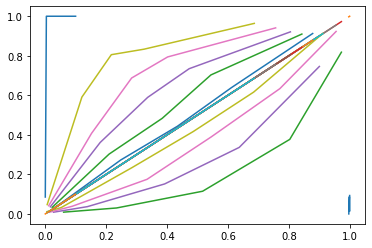

In [10]:
for plot in plots:
    plt.plot(plot[0], plot[1])
    plt.plot(plot[0], plot[0])
    
plt.show()

In [11]:
outputs_val = torch.stack([torch.sigmoid(output_val.squeeze()) for output_val in outputs_val], dim=1).detach().numpy().round(3)

In [12]:
# optimal cutoff point
cutoff = np.percentile(outputs_val[:, 5], 100 * (1-y_train.values.mean()))
cutoff

0.27900001406669617

In [13]:
preds = (outputs_val > cutoff)

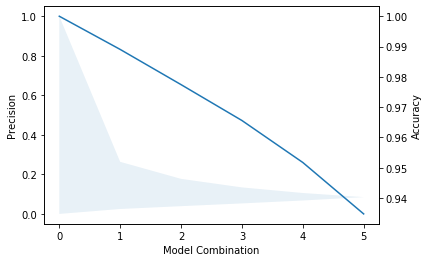

In [31]:
make_precision_accuracy_plot(outputs_val, preds, y_test)

Text(0, 0.5, 'Uncertainty')

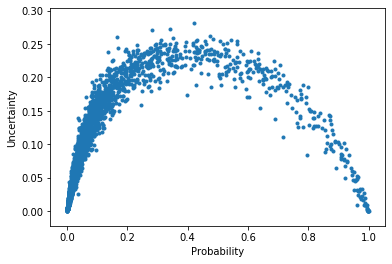

In [70]:
uncertainties = np.std(outputs_val[:, 1:9], axis=-1)
# uncertainties = outputs_val[:, 1] - outputs_val[:, 9]
# uncertainties = outputs_val[:, 2] - outputs_val[:, 8]
# uncertainties = outputs_val[:, 3] - outputs_val[:, 7]
# uncertainties = outputs_val[:, 4] - outputs_val[:, 6]

preds_50 = preds[:, 5]
# plt.scatter(outputs_val[:, 5][preds_50 == y_test.squeeze().values], uncertainties[preds_50 == y_test.squeeze().values], marker='.')
# plt.scatter(outputs_val[:, 5][preds_50 != y_test.squeeze().values], uncertainties[preds_50 != y_test.squeeze().values], marker='.')
plt.scatter(outputs_val[:, 5], uncertainties, marker='.')
plt.xlabel('Probability')
plt.ylabel('Uncertainty')


In [71]:
y_true = y_test.values.squeeze(-1)
y_prob = outputs_val[:, 5]
y_unc = uncertainties

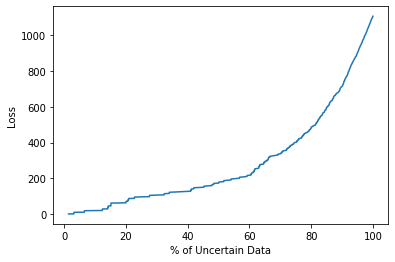

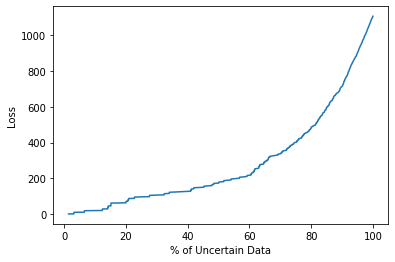

In [72]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'sum'})

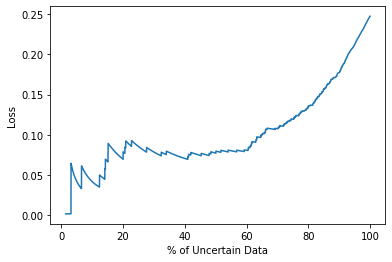

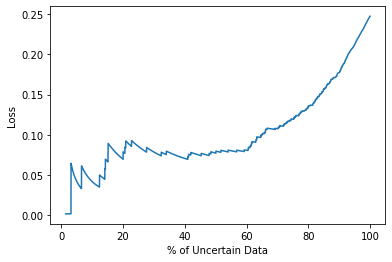

In [73]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'mean'})

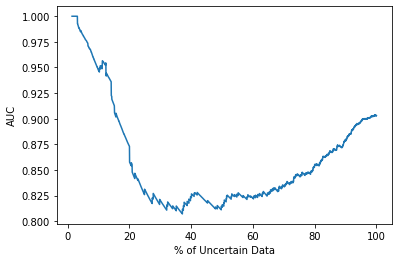

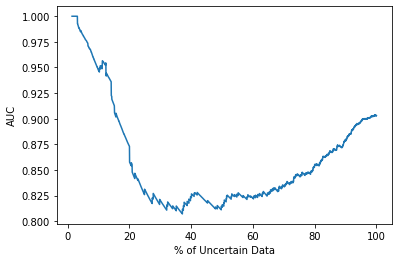

In [74]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'AUC', performance_fn=roc_auc_score)

In [75]:
from utils import loss_at_50

In [76]:
loss_at_50(y_true, y_prob, uncertainties)

172.92898128018714

In [77]:
cross_entropy(y_true, y_prob, reduction='sum')

1108.550228340784

In [78]:
false_predictions = preds_50 != y_test.squeeze()

In [79]:
roc_auc_score(false_predictions, uncertainties)

0.8706948331451205

In [80]:
average_precision_score(false_predictions, uncertainties)

0.39529600254485

## Asymmetric entropy baseline

In [93]:
def asymmetric_entropy(p, w):
    return (p * (1 - p)) / ((-2 * w + 1) * p + w ** 2)


In [100]:
# uncertainties = asymmetric_entropy(outputs_val[:, 5], y_train.values.mean())
uncertainties = asymmetric_entropy(outputs_val[:, 5], 1 - cutoff)

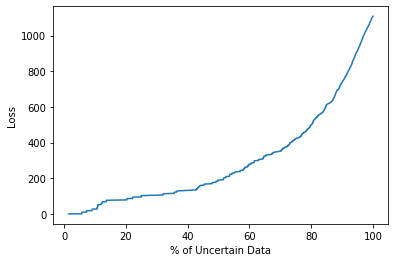

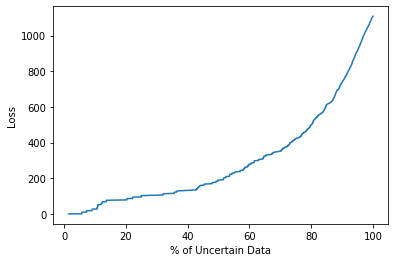

In [101]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'Loss', performance_fn_args={'reduction': 'sum'})

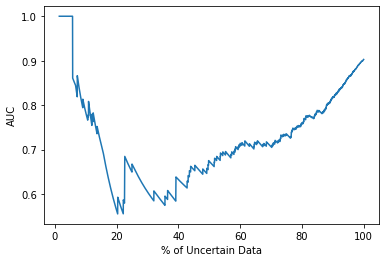

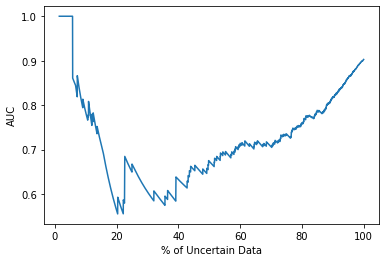

In [102]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'AUC', performance_fn=roc_auc_score)

In [103]:
loss_at_50(y_true, y_prob, uncertainties)

189.54604581161402

In [104]:
roc_auc_score(false_predictions, uncertainties)

0.854295756206936

In [105]:
average_precision_score(false_predictions, uncertainties)

0.28245246294197046